## Семинар 8: "Снижение размерности"

ФИО:

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
X = fetch_olivetti_faces()['data']

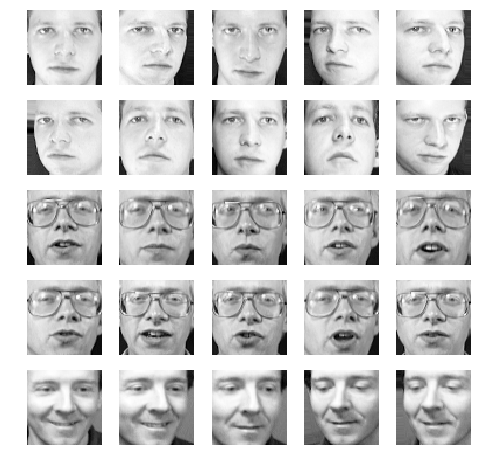

In [3]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

Подсказка: используйте метод <b>.components_</b>

In [5]:
model = PCA(n_components=100)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
data = model.components_

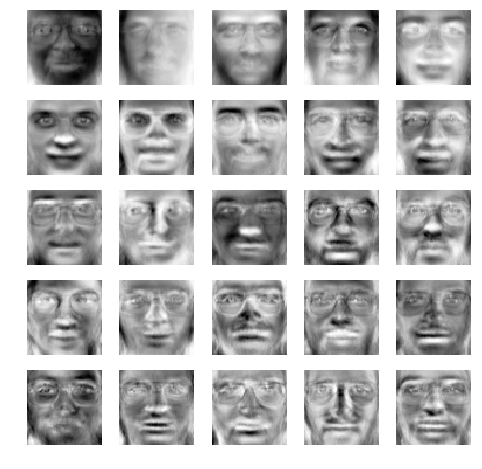

In [7]:
plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(data[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

In [8]:
data = model.transform(X)
reconstructions = model.inverse_transform(data)

In [41]:
((reconstructions - X)**2).sum()

11376.591

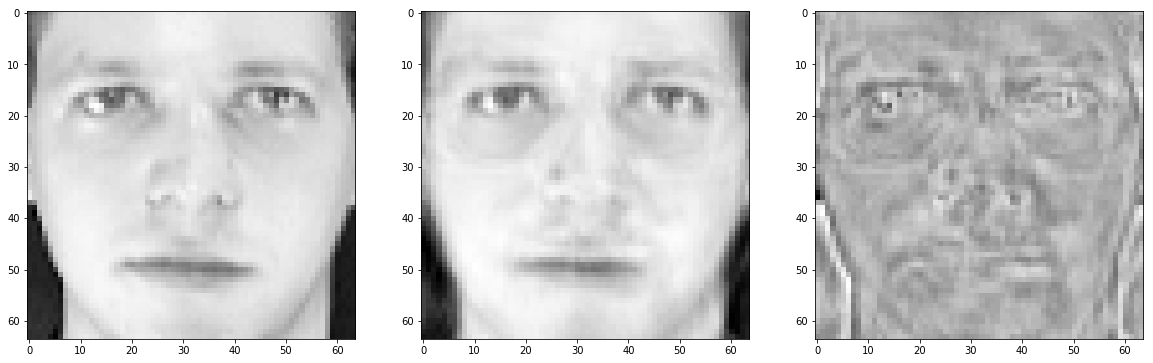

In [10]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(X[0].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 2)
plt.imshow(reconstructions[0].reshape((64, 64)), cmap=plt.cm.Greys_r)
plt.subplot(1, 3, 3)
plt.imshow((reconstructions - X)[0].reshape((64, 64)), cmap=plt.cm.Greys_r)

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>

Подсказка: используйте методы <b>.explained\_variance\_ratio\_</b> и <b>np.cumsum()</b>

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

In [30]:
errors = []
components = range(1, 10)

for n_comp in components:
    model = PCA(n_components=n_comp)
    model.fit(X)
    data = model.transform(X)
    reconstructions = model.inverse_transform(data)
    errors.append(((reconstructions - X)**2).sum() / X.shape[0])

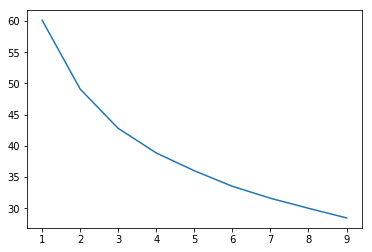

In [31]:
plt.plot(components, errors)

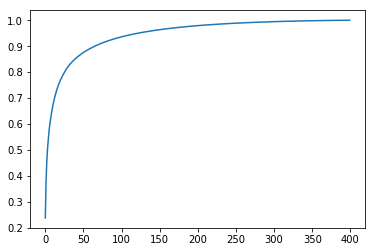

In [32]:
model = PCA()
model.fit(X)
plt.plot(np.cumsum(model.explained_variance_ratio_))

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют? Чему соответствуют главные компоненты?</i>

In [14]:
def plot_dataset(X, emb, margin=50, frame=2000., imsize=64):
    assert(emb.shape[1] == 2)
    emb = np.array((emb - emb.min(0)) * (frame / (emb.max(0) - emb.min(0))) + margin, dtype = np.int)
    image = np.zeros((int(emb[:, 0].max() + margin + imsize), int(emb[:, 1].max() + margin + imsize))) + 1
    for k in range(X.shape[0]):
        image[emb[k, 0]:emb[k, 0]+64, emb[k, 1]:emb[k, 1]+64] = X[k].reshape(64, 64)
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap="Greys_r")
    plt.axis("off")
    plt.show()

In [15]:
model = PCA(n_components=2)
model.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

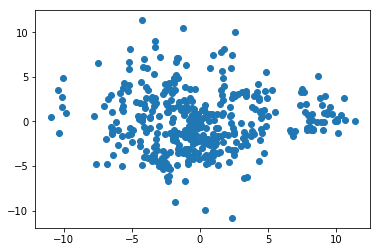

In [16]:
data = model.transform(X)
plt.scatter(data[:,0], data[:,1])

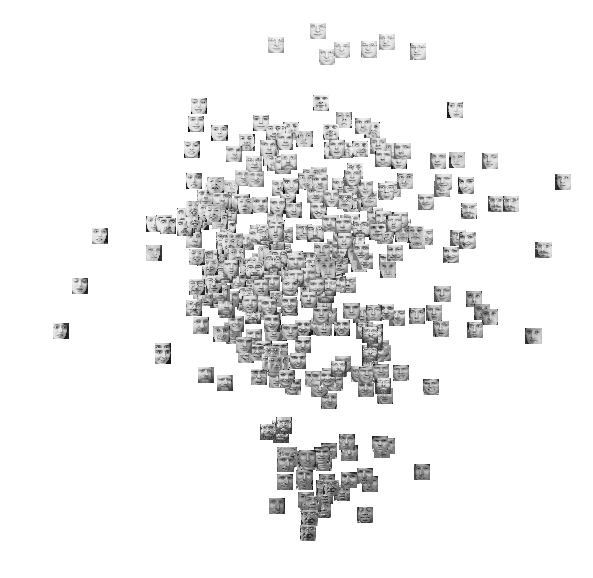

In [17]:
plot_dataset(X, data)

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

<i> 2.2 Какое качество восстановления удалось получить?</i>

In [18]:
from torch.utils.data import Dataset, DataLoader
import sys

In [19]:
class FaceDataset(Dataset):
    def __init__(self, X, transform=None):
        self.X = X

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

In [20]:
dataset = FaceDataset(X)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [21]:
def fully_connected(arc, last_nonlin = True):
    layers = []
    
    for i in range(len(arc) - 1):
        layers.append(nn.Linear(arc[i], arc[i + 1]))
        if i != len(arc) - 2 or last_nonlin:
            layers.append(nn.LeakyReLU())
            
    return nn.Sequential(*layers)

class AE(nn.Module):
    def __init__(self, arc_encoder, arc_decoder):
        super(AE, self).__init__()
        
        self.encoder = fully_connected(arc_encoder)
        self.decoder = fully_connected(arc_decoder)
        
    def forward(self, X):
        return self.decoder(self.encoder(X))

In [22]:
model = AE((4096, 200, 10), [10, 100, 4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
for epoch in range(100):
    losses = []
    for x in dataloader:
        x_batch = Variable(x, requires_grad=True)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_preconstruct = model(x_batch)
        loss_batch = loss(x_preconstruct, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {} {}'.format(epoch, np.mean(losses)))

 99 0.010313346832990646

In [24]:
emb = model.encoder(Variable(torch.Tensor(X))).data.numpy()
reconstr = model(Variable(torch.Tensor(X))).data.numpy()

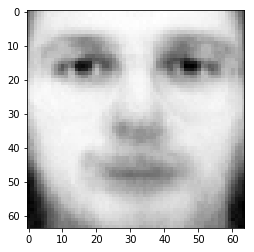

In [25]:
plt.imshow(reconstr[0].reshape(64, 64), cmap=plt.cm.Greys_r)

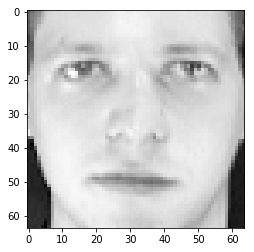

In [26]:
plt.imshow(X[0].reshape(64, 64), cmap=plt.cm.Greys_r)

<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>

<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

In [46]:
errors = []
components = range(5, 20)

for n_comp in components:
    glob_losses = []
    
    model = AE((4096, 200, n_comp), [n_comp, 100, 4096])
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(20):
        losses = []
        for x in dataloader:
            x_batch = Variable(x, requires_grad=True)
            y_batch = Variable(x, requires_grad=False)
            model.zero_grad()
            x_preconstruct = model(x_batch)
            loss_batch = loss(x_preconstruct, y_batch)
            loss_batch.backward()
            optimizer.step()
            losses.append(loss_batch.data[0])
        #sys.stdout.write('\r {} {}'.format(epoch, np.mean(losses)))
    emb = model.encoder(Variable(torch.Tensor(X))).data.numpy()
    reconstr = model(Variable(torch.Tensor(X))).data.numpy()
    errors.append(((reconstr - X) ** 2).sum() / X.shape[0])

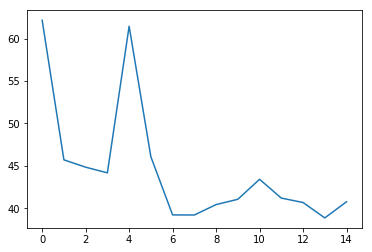

In [47]:
plt.plot(errors)

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [49]:
model = AE((4096, 200, 2), [2, 100, 4096])
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [50]:
for epoch in range(100):
    losses = []
    for x in dataloader:
        x_batch = Variable(x, requires_grad=True)
        y_batch = Variable(x, requires_grad=False)
        model.zero_grad()
        x_preconstruct = model(x_batch)
        loss_batch = loss(x_preconstruct, y_batch)
        loss_batch.backward()
        optimizer.step()
        losses.append(loss_batch.data[0])
    sys.stdout.write('\r {} {}'.format(epoch, np.mean(losses)))

 99 0.011661790087819171

In [51]:
emb = model.encoder(Variable(torch.Tensor(X))).data.numpy()

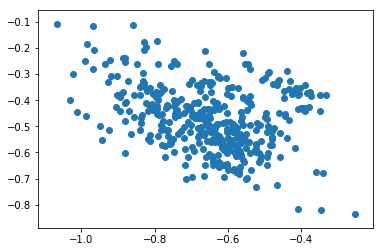

In [81]:
plt.scatter(emb[:,0], emb[:,1])

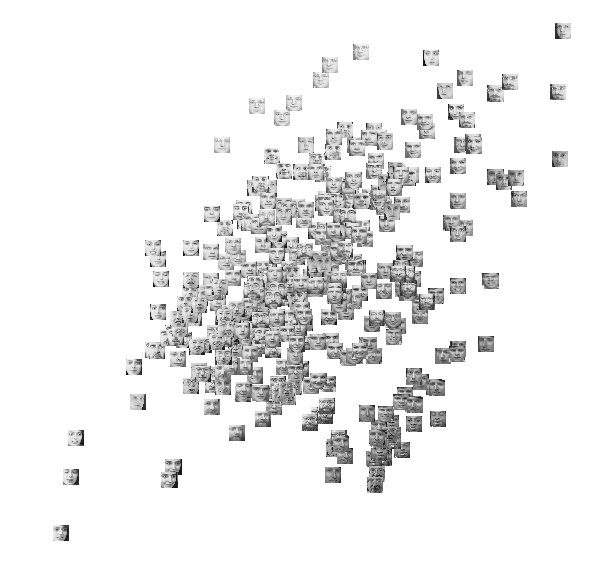

In [102]:
plot_dataset(X, emb)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: